In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
MODEL_NAME = "vinai/phobert-base-v2"
MAX_LEN = 80

In [2]:
data=pd.read_csv('Label.csv')
data=data.dropna()
data

,Comment,Label
0,hội_chợ mà giá đồ_ăn rẻ hơn bên ngoài nghe mà ...,-1
1,ăn tới chết,0
2,bữa không biết luôn,0
3,vô lẹ dẫn đi,1
4,ăn befsteak đi lẹe,1
...,...,...
2989,mai ngọc ánh nv cocomoco_lực điền,0
2990,chắc dồn nén căm_hờn vào đó rồi,0
2991,vài bữa cơ_bắp cuồn_cuộn,0
2992,nó cay thag_bồ lắm đây,-1


In [3]:
#convert Label, if Label = -1 -> 0, if Label = 0 -> 1, if Label = 1 -> 2
data['Label'] = data['Label'].apply(lambda x: x+1)

In [4]:
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [5]:
device

device(type='cuda', index=0)

In [6]:
data.Label.value_counts()

1    1339
0    1000
2     646
Name: Label, dtype: int64

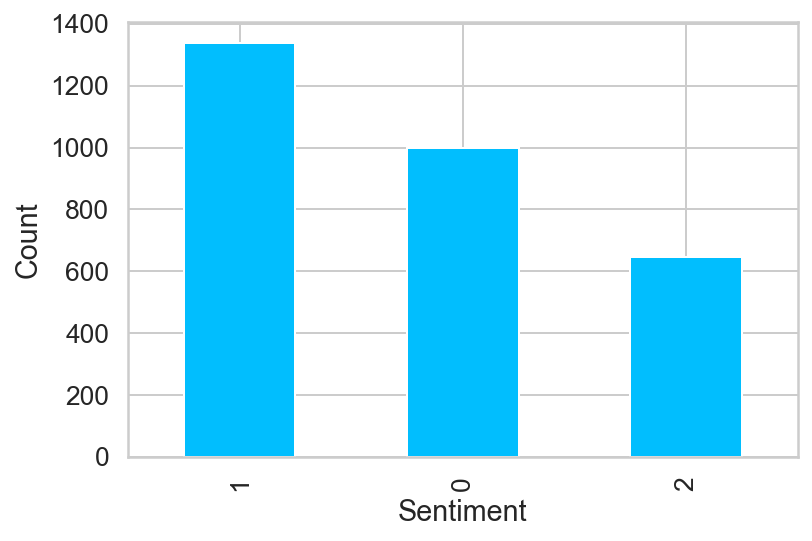

In [7]:
class_names = ['negative', 'neutral', 'positive']
data.Label.value_counts().plot(kind= 'bar', y = class_names)
plt.ylabel('Count')
plt.xlabel('Sentiment')

# Show the plot
plt.show()

In [8]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer

In [9]:
# Set the model name
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

</s> 2
<s> 0
<pad> 1
<unk> 3


In [11]:
token_lens = []

# Iterate through the content slide
for txt in data.Comment:
    
    tokens = tokenizer.encode_plus(txt, padding="max_length", truncation=True, max_length=80, return_tensors="pt")
    token_lens.append(len(tokens))

In [12]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, comments, targets, tokenizer, max_len):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.comments)
    
    # get item magic method
    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [13]:
RANDOM_SEED = 10

In [14]:
df_train, df_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [15]:
print(df_train.shape, df_val.shape, df_test.shape)

(2686, 2) (149, 2) (150, 2)


In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        comments=df.Comment.to_numpy(),
        targets=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [17]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['comment', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


In [19]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [20]:
n_classes = 3

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(self.phobert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

In [22]:
class_names

['negative', 'neutral', 'positive']

In [23]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Number of iterations 
EPOCHS = 20

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
model

In [26]:
model = model.to(device)

In [27]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)


        outputs = model(
            input_ids = input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        print(outputs.size(), targets.size())
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state_1.bin')
        best_accuracy = val_acc

In [45]:

def encode_predict(comment_test):
    encoded_review = tokenizer.encode_plus(
        comment_test,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    # print(f'{comment_test}',':', f'{class_names[prediction]}')
    return prediction


In [48]:
df=pd.read_csv('Cleaned.csv')
data1=df[3000:3100]
data1

,user,Comment,comment_at
3000,thaothao150495,thoa yến_giã bằng cả sanh mạng,6ngày trước
3001,thodanhahaha,ước lần được hộp thư,4ngày trước
3002,kim_ngan909,lê bữa nào qua mua cho em ly thử đê,5ngày trước
3003,user8482191290626,thật là mãnh_liệt,3giờ trước
3004,nttxh,ni là vì cả đam_mê cho chủ,5ngày trước
...,...,...,...
3095,vtm909,jã bằng cả táh mạg,5ngày trước
3096,pgbhanghieu1628,vừa mặn vừa chua,5ngày trước
3097,chubeandaihamchoi76,sau_này có chồng,5ngày trước
3098,thamngo77,về nhà chồng mà ré tiếng nào là chết liền,5ngày trước


In [51]:
data1['Label'] = data1['Comment'].apply(encode_predict).apply(lambda x: x.item() if hasattr(x, 'item') else x)

In [55]:
data1

,user,Comment,comment_at,Label
3000,thaothao150495,thoa yến_giã bằng cả sanh mạng,6ngày trước,1
3001,thodanhahaha,ước lần được hộp thư,4ngày trước,1
3002,kim_ngan909,lê bữa nào qua mua cho em ly thử đê,5ngày trước,2
3003,user8482191290626,thật là mãnh_liệt,3giờ trước,2
3004,nttxh,ni là vì cả đam_mê cho chủ,5ngày trước,2
...,...,...,...,...
3095,vtm909,jã bằng cả táh mạg,5ngày trước,1
3096,pgbhanghieu1628,vừa mặn vừa chua,5ngày trước,0
3097,chubeandaihamchoi76,sau_này có chồng,5ngày trước,1
3098,thamngo77,về nhà chồng mà ré tiếng nào là chết liền,5ngày trước,0
